In [540]:
%matplotlib inline
import numpy as np
from pandas import DataFrame, Series
from geostatsmodels import utilities, kriging, variograms, model, geoplot
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform, cdist
import statsmodels.formula.api as sm

In [2]:
from __init__ import *
from rain import *
from common import *

In [3]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [4]:
%load_ext autoreload

In [5]:
%aimport common
%aimport rain

In [312]:
def get_fit(df, col, latlon=True, plot=False):
    df = df[['lon', 'lat', col]].dropna(how='any')
    df.columns = ['lon', 'lat', 'col']
    result = sm.ols(formula="col ~ lon + lat", data=df).fit()
    fit = result.params['Intercept'] + result.params['lon']*df.lon +result.params['lat']*df.lat
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        for l, ax in zip(['lon', 'lat'], axes):
            ax.scatter(x=df[l], y=df.col)
            ax.scatter(df[l], fit, c='r')
            ax.set_ylabel('Rain Rate (mm/hr)')
            ax.set_xlabel(l)
            ax.set_title('Trend in ' + l)
    return fit

In [408]:
rg.get_rainiest(10, time_step='1H', base=0)
z = rg.rainiest[:]

z.X = z.X -z.X.min()
z.Y = z.Y -z.Y.min()

res = z[range(5)]
for col in z.columns[5:]:
    fit = get_fit(z, col)
    res = res.join(pd.DataFrame({col: z[col]-fit+z[col].mean()}))

In [712]:
from rpy2.robjects import pandas2ri, r
pandas2ri.activate()

In [719]:
pandas2ri.pandas2ri(res);


In [721]:
r.data('iris')
df_iris = pandas2ri.ri2pandas(r['iris'])

NotImplementedError: Conversion from rpy2 DataFrame to pandas' DataFrame

Infill iteration 1 of 5....
Infill iteration 2 of 5....
Infill iteration 3 of 5....
Infill iteration 4 of 5....
Infill iteration 5 of 5....


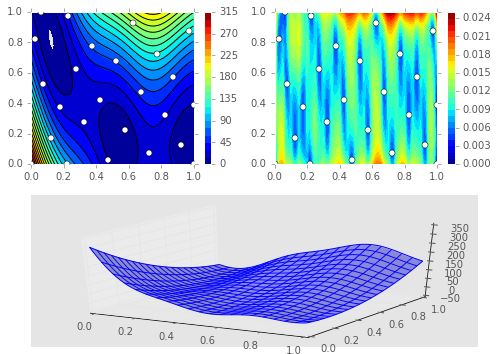

In [704]:
import pyKriging  
from pyKriging.krige import kriging  
from pyKriging.samplingplan import samplingplan

# The Kriging model starts by defining a sampling plan, we use an optimal Latin Hypercube here
sp = samplingplan(2)  
X = sp.optimallhc(20)

# Next, we define the problem we would like to solve
testfun = pyKriging.testfunctions().branin  
y = testfun(X)

# Now that we have our initial data, we can create an instance of a Kriging model
k = kriging(X, y, testfunction=testfun, name='simple')  
k.train()

# Now, five infill points are added. Note that the model is re-trained after each point is added
numiter = 5  
for i in range(numiter):  
    print 'Infill iteration {0} of {1}....'.format(i + 1, numiter)
    newpoints = k.infill(1)
    for point in newpoints:
        k.addPoint(point, testfun(point)[0])
    k.train()

# And plot the results
k.plot()  

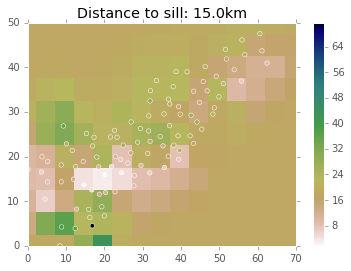

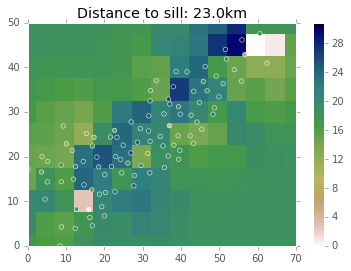

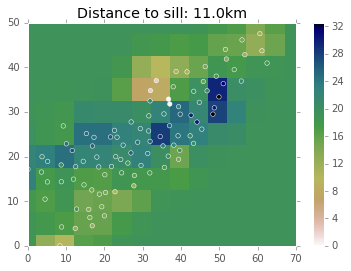

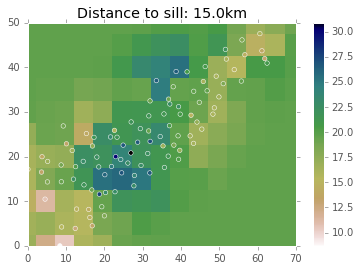

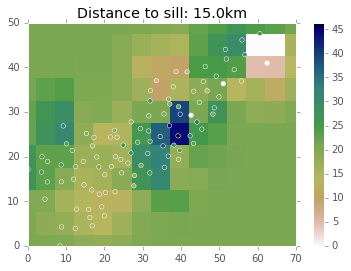

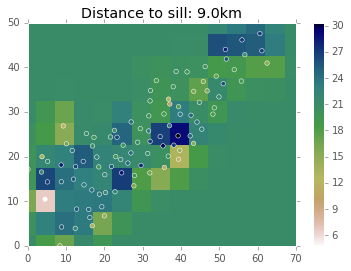

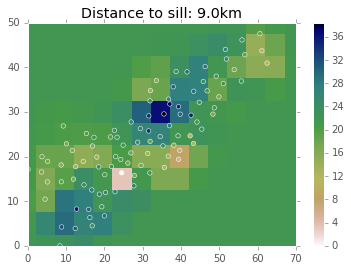

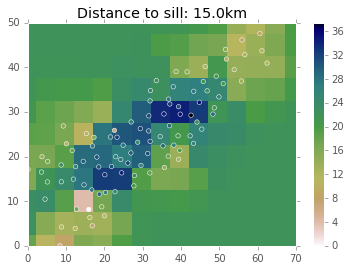

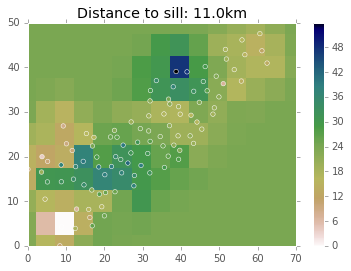

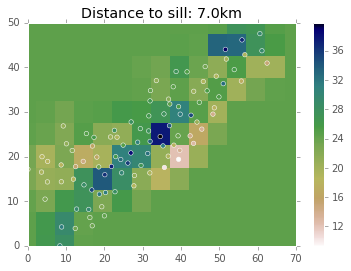

In [549]:
tolerance = 1
lags = np.arange( tolerance, 40, tolerance*2 )
step = 5

for col in res.columns[5:]:
    P = np.array(res[['X','Y',col]][res[col].notnull()])
    sill = np.var(P[:,2])
    bar = variograms.semivariogram(P, lags, tolerance)
    for i in range(len(bar[1])):
        if bar[1][i] > sill:
            dist_to_sill = bar[0][i]
            break
    #svm = model.semivariance(model.spherical, [dist_to_sill, sill])
    #geoplot.semivariogram( P, lags, tolerance, model=svm )
    covfct = model.covariance( model.spherical, ( dist_to_sill, sill ) )
    grid = [[x,y] for x in range(0, 70+step, step) for y in range(0, 50+step, step)]
    x = [pt[0] for pt in grid]
    y = [pt[1] for pt in grid]
    k = kriging.krige(P, covfct, grid, method='simple', N=1)
    
    fig, ax = plt.subplots()
    vmin = max(0, P[:,2].min())
    vmax = P[:,2].max()
    ax.scatter(x, y, c=k[0], cmap='gist_earth_r', marker='s', edgecolors='none', s=step*100, vmin=vmin, vmax=vmax)
    scat = ax.scatter(res.X, res.Y, c=res[col], cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
    ax.set_xlim(0,70)
    ax.set_ylim(0,50)
    ax.set_title('Distance to sill: {dts}km'.format(dts=dist_to_sill))
    plt.colorbar(scat)
    plt.show()

In [550]:
df = pd.DataFrame(data=k[0], index=pd.Index(grid), columns=['krige'])

In [551]:
df[0:].idxmax()

krige    [35, 25]
dtype: object

In [571]:
def kmatrices( data, covfct, u, N=0 ):
    '''
    Input  (data)  ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (u)     unsampled point
           (N)     number of neighboring points
                   to consider, if zero use all
    '''
    # u needs to be two dimensional for cdist()
    if np.ndim( u ) == 1:
        u = [u]
    # distance between u and each data point in P
    d = cdist( data[:,:2], u )
    # add these distances to P
    P = np.hstack(( data, d ))
    # if N>0, take the N closest points,
    if N > 0:
        P = P[d[:,0].argsort()[:N]]
    # otherwise, use all of the points
    else:
        N = len( P )

    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # check for nan values in k
    if np.any( np.isnan( k ) ):
        raise ValueError('The vector of covariances, k, contains NaN values')
    # cast as a matrix
    k = np.matrix( k ).T
    # form a matrix of distances between existing data points
    K = utilities.pairwise( P[:,:2] )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    print K
    # check for nan values in K
    if np.any( np.isnan( K ) ):
        raise ValueError('The matrix of covariances, K, contains NaN values')
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )

    return K, k, P

In [583]:
model.covariance( model.spherical, ( 7.5, sill ) )

<function geostatsmodels.model.inner>

In [683]:
a=7
c=sill
h=7.5826

In [664]:
lta = lambda x: c*( 1.5*(x/a) - 0.5*(x/a)**3.0 )
gta = lambda x: c+x*0

In [673]:
print c - gta(0)

0.0


In [697]:
K = np.array((0.,           7.58264462 ,  4.24546851,   7.58264462,   0.,11.14646046,4.24546851,11.14646046 ,  0.        ))

In [677]:
co = model.covariance(model.spherical, (a, c))

In [691]:
def typetest( h, a, lta, gta ):
    '''
    Input:  (h)   scalar or NumPy ndarray
            (a)   scalar representing the range parameter
            (lta) function to perfrom for values less than (a)
            (gta) function to perform for values greater than (a)
    Output:       scalar or array, depending on (h)
    '''
    # if (h) is a numpy ndarray, then..
    try:
        print 1
        # apply lta() to elements less than a
        lt = lta( h[ np.where( h <= a ) ] )
        print lt
        # apply gta() to elements greater than a
        gt = gta( h[ np.where( h > a ) ] )
        print gt
        return np.hstack((lt,gt))
    # otherwise, if (h) is a scalar..
    except TypeError:
        if h <= a:
            return lta( h )
        else:
            return gta( h )

In [703]:
typetest(np.array([0,7.6,7.6,0]), 7.0, lta, gta )

1
[ 0.  0.]
[ 45.53852144  45.53852144]


array([  0.        ,   0.        ,  45.53852144,  45.53852144])

In [684]:
model.spherical(K, a, c)

array([  0.        ,   0.        ,  45.53852144,  45.53852144])

In [679]:
co(K)

array([ 45.53852144,  45.53852144,   0.        ,   0.        ])

In [694]:
kmatrices(P,  model.covariance( model.spherical, ( a, c ) ), [5,5], N=3)

[  0.           7.58264462   4.24546851   7.58264462   0.          11.14646046
   4.24546851  11.14646046   0.        ]
[ 45.53852144   9.18978419  45.53852144   9.18978419  45.53852144   0.           0.
   0.           0.        ]


(matrix([[ 45.53852144,   9.18978419,  45.53852144],
         [  9.18978419,  45.53852144,   0.        ],
         [  0.        ,   0.        ,   0.        ]]), matrix([[ 11.58254343],
         [  2.99986452],
         [  1.2824542 ]]), array([[  8.7968297 ,   4.22171532,  31.40293808,   3.87577641],
        [  4.47400082,  10.45145448,  22.71039158,   5.47677196],
        [  8.34836272,   0.        ,  30.37216953,   6.01760192]]))

In [635]:
kriging.simple(P, covfct, [5,5], N=1)

(26.28976402573103, 6.5262965891821638)

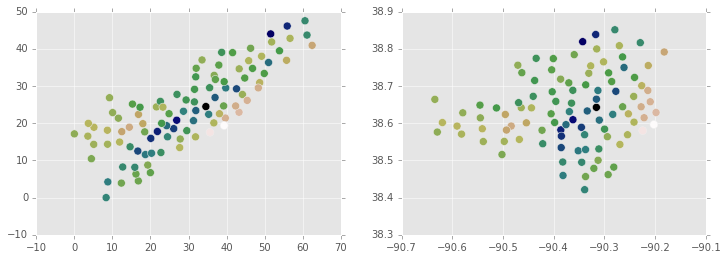

In [349]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].scatter( res.X, res.Y, c=res[col], s=64,cmap='gist_earth_r')
axes[1].scatter( res.lon, res.lat, c=res[col], s=64,cmap='gist_earth_r')

In [383]:
covfct = model.covariance( model.spherical, ( dist_to_sill, sill ) )

In [385]:
covfct

<function geostatsmodels.model.inner>

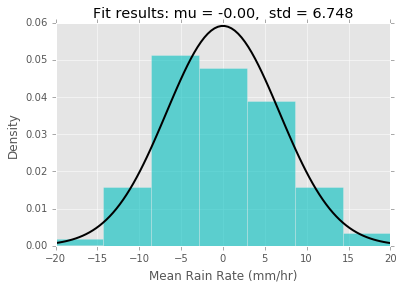

In [366]:
hrange = (-20,20)
mu, std = norm.fit(res[col].dropna())
ahist=plt.hist(res[col].dropna(), bins=7, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = hrange
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.3f" % (mu, std)
plt.title(title)
plt.xlabel('Mean Rain Rate (mm/hr)')
plt.ylabel('Density')

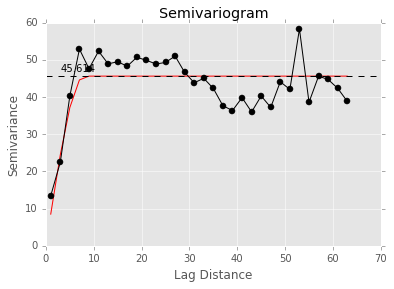

In [132]:
sill = np.var(P[:,2])
tolerance = 1
lags = np.arange( tolerance, 65, tolerance*2 )
svm = model.semivariance(model.spherical, [8, sill])
geoplot.semivariogram( P, lags, tolerance, model=svm )

In [367]:
covfct = model.covariance( model.spherical, ( 8, sill ) )

In [368]:
grid = [[x,y] for x in range(0,70,2) for y in range(0,50,2)]
x = [pt[0] for pt in grid]
y = [pt[1] for pt in grid]
k = kriging.krige(P, covfct, grid, method='simple', N=2)

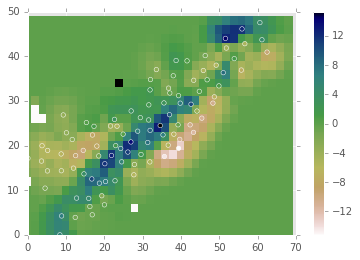

In [370]:
fig, ax = plt.subplots()
vmin = P[:,2].min()
vmax = P[:,2].max()
ax.scatter(x, y, c=k[0], cmap='gist_earth_r', marker='s', edgecolors='none', s=80, vmin=vmin, vmax=vmax)
scat = ax.scatter(res.X, res.Y, c=res[col], cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
ax.set_xlim(0,70)
ax.set_ylim(0,50)
plt.colorbar(scat)
plt.show()

In [107]:
grid = [[x,y] for x in range(0,70,5) for y in range(0,50,5)]

x = [pt[0] for pt in grid]
y = [pt[1] for pt in grid]
k = kriging.krige(P, covfct, grid, method='simple', N=2)

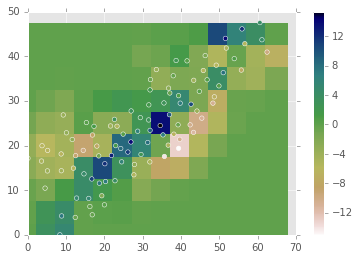

In [108]:
fig, ax = plt.subplots()
vmin = P[:,2].min()
vmax = P[:,2].max()
ax.scatter(x, y, c=k[0], cmap='gist_earth_r', marker='s', edgecolors='none', s=500, vmin=vmin, vmax=vmax)
scat = ax.scatter(z.X, z.Y, c=z.residuals, cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
ax.set_xlim(0,70)
ax.set_ylim(0,50)
plt.colorbar(scat)
plt.show()

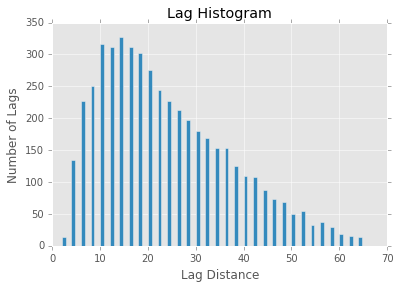

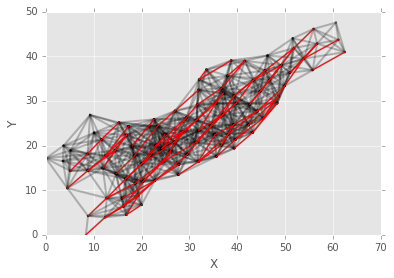

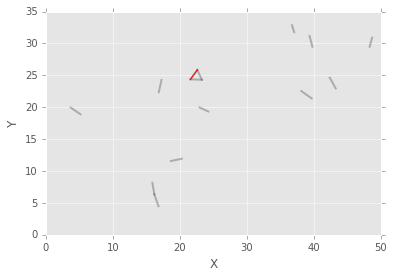

In [131]:
pw = utilities.pairwise(P)
geoplot.laghistogram( P, pw, lags, tolerance )

geoplot.anisotropiclags( P, pw, lag=1, tol=8, angle=39, atol=10)

geoplot.anisotropiclags( P, pw, lag=1, tol=1, angle=39, atol=10)